# 1. Import Packages

In [ ]:
import matplotlib.pyplot as plt
import graphviz 
import seaborn as sns 
import plotly.express as px
from plotnine import *

import pandas as pd
import numpy as np
from scipy import stats 

from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier
from sklearn.ensemble import RandomForestClassifier

from sklearn import tree
from sklearn.metrics import accuracy_score,f1_score,precision_score,roc_auc_score,recall_score,confusion_matrix
from sklearn.model_selection import train_test_split

# 2. Import Data

For teaching team
Please change the location variable to your desired directory to read in hackaton files.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# please change your desired directory here
location = '/content/drive/My Drive/DSA3101 Group 9/data/'

Mounted at /content/drive


In [ ]:
# run the mount drive below
# put the data folder on the root directory of your google drive
df_catinfo = pd.read_csv(location + 'DSA3101_Hackathon_Categories_Information.csv')
df_hackdata= pd.read_csv(location + 'DSA3101_Hackathon_Data.csv', parse_dates=['Date'])
df_paneldemo = pd.read_excel(location + 'DSA3101_Hackathon_Panelists_Demographics.xlsx')

In [ ]:
df_hackdata.head()

,Panel ID,Date,Category,Pack Size,Volume,Spend
0,Panel 101011101,2017-07-02,CSD,1,1.5,1.5
1,Panel 101011101,2017-07-02,Soy Milk,1,1.0,2.8
2,Panel 101011101,2017-07-02,Cooking Sauces,1,0.3,3.2
3,Panel 101011101,2017-07-02,Coconut Milk,2,0.4,5.3
4,Panel 101011101,2017-07-02,Chocolate,1,0.2,6.6


In [ ]:
df_paneldemo['Ethnic'] = df_paneldemo.Ethnicity.apply(lambda x: x.split(" ")[-1])

# 3. Idenitifying "Churned" Customers  

In this assignment, we interested in finding out the possibility of churning, using Decision Tree. Using the decision tree classification, we will be able to obtain some predictors that are significant in prediction the churn behaviour of our customer.   

For example, if decision tree shows that customers who made purchase on "product X" tends to churn, it is likely that our services on "product X" are under expectation. This then suggest that we can device strategies to improve our service on "product X".  

**Feature Engineering**  
There is a very significant challenge in using Decision Tree to predict the outcome, that is, we are **not provided with the "churn" data** for each Panelist(customer). Therefore, we are using the following rules to simulate the churning behaviour of each Panelist.  

Only use the data up to the year 2019(excluding 2020 because 2020 data is incomplete), we use information from the year 2018 to look for customer who has visited us in the past,  and check against the data in 2019, customers who did not appear in 2020  will be considered as cherned, this allow us to conduct surpervised analysis on the chern  classification problem.   


<center>Example:  </center> 
<center>Customers who appeared in 2018 & before = {A, B, C}</center> 
<center>Customers who appeared in 2019 = {A, D}  </center> 

Customer | Churned  
 :--: | :--:  
 A | 0  
 B | 1  
 C | 1
 D | 0   
  

In [ ]:
# create a copy so that the original df is not altered
df_hackdata_tree = df_hackdata.copy()
# only use data 2019 and before
df_hackdata_tree = df_hackdata_tree[df_hackdata_tree.Date < "2020-01-01"]

df_cust_pool = df_hackdata_tree[df_hackdata_tree.Date < "2019-01-01"]
df_cust_2019 = df_hackdata_tree[df_hackdata_tree.Date >= "2019-01-01"]
# df_cust_2019

df_cust_pool = df_cust_pool['Panel ID'].unique()
df_cust_2019 = df_cust_2019['Panel ID'].unique()

cherned = set(df_cust_pool) - set(df_cust_2019)
# df_hackdata['cherned'] = df_hackdata_tree["Panel ID"].apply(lambda x: 1 if x in cherned else 0)

In [ ]:
df_hackdata_tree.sample(20)

,Panel ID,Date,Category,Pack Size,Volume,Spend
291053,Panel 201151101,2017-10-29,Biscuits,1,0.2,2.8
369226,Panel 206096101,2019-08-04,Instant Noodles,1,5.0,4.2
65595,Panel 117008101,2017-07-30,Sugar,3,3.0,8.7
901499,Panel 444153101,2018-03-04,Instant Noodles,2,2.0,3.6
157901,Panel 152023101,2019-06-23,Flour,2,0.3,5.4
1033505,Panel 800201201,2018-07-01,Tonic Food Drink,1,0.2,4.4
386003,Panel 210043101,2018-07-01,Cordials,1,1.0,8.8
462489,Panel 225230101,2019-04-07,Rice,1,5.0,31.0
992081,Panel 800161601,2017-09-17,Fruit/Veg Juices,1,1.5,4.2
502436,Panel 245255101,2018-02-25,Cereal Beverage,1,0.5,11.5


# 4. Classification Tree

## 4.1 Data Preparation  

The dataframe to use to decision tree shall include:   
* RFM
* packsize purchased for each category 
* demographic data for each panelist  

In order to classify each panelist according to churned or not churned, we aim to gather as much information as possible for each panelist, that includes their purchasing habit(RFM), food consumption(purchase history) and their demographic data.  

We aim to apply decision tree algorithm on these variables, and identify the most(more) meaningful variable that can explain to us why some of our customers are leaving us.  

The completed dataframe that contains all information about each panelist can be found below after transformation of data is completed, it will be a high-dimensional data that has many columns for each panelist we have.  

### 4.1.1 RFM
Convert the data using RFM values 

In [ ]:
def recency_ver2(group):
    '''
    compute the recency values by counting the number of days
    from the most recent 3 effective visits 
    '''

    spendings = group.Spend
    dates = group.Date
    date_spending = zip(dates, spendings)
    # a sorted tuple of (date, spending on date)
    date_spending = sorted(date_spending, reverse = True)

    today = pd.Timestamp.today()
    recency_value = 1
    day_count = 0

    # go through each visit, starting from the most recent visits
    for date, spend in date_spending:
       if stats.percentileofscore(spendings, spend) >= 40:
         # find a visit that is significant enough 
         day_count += 1
         recency_value *= (today - date).days  
         if day_count == 3:
           break
    
    # return the geometric mean of the top three recent purchases
    return recency_value**(1/3)

def frequency(date_series):
  return len(date_series)

def monetary(spend_series):
  return sum(spend_series) / len(spend_series)

def getRFMvalues(df, in_place = False):
    '''
    df is a dataframe that contains at least the following columns:
        * Panel ID
        * Date
        * Spend
    
    specifically, it takes in the original hackaton data, untransformed
    ''' 
    # if edit in-place
    # preferrably not to edit the original df
    df = df.copy() if in_place else df

    
    # collapse each visit into one row
    df = df.reset_index()
    # payment made on the same day by the 
    # same customer are considered as one single visit
    df_grouped = df.groupby(['Panel ID', 'Date']).agg({"Spend": sum})
    df_grouped = df_grouped.reset_index()
    df_grouped = df_grouped.groupby('Panel ID')
    
    df_rfm = df_grouped.agg({'Date': frequency,
                             'Spend': monetary})
    df_rfm = df_rfm.rename(columns = {'Date': 'Frequency', 'Spend': 'Monetary'})

    
    # df_rfm['Recency'] = df_grouped.Date.apply(recency)
    df_rfm['Recency'] = df_grouped.apply(recency_ver2)
    df_rfm = df_rfm.fillna(1000)

    return df_rfm

In [ ]:
df_rmf = getRFMvalues(df_hackdata_tree)

In [ ]:
df_rmf.head()

,Frequency,Monetary,Recency
Panel ID,,,
Panel 101011101,90,30.807778,330.647946
Panel 101016101,60,26.891667,314.544648
Panel 101019101,132,45.103788,323.798228
Panel 101024101,132,39.096970,326.018266
Panel 105009103,132,30.817424,312.212134


### 4.1.2 Packsize Purchased  

For each panelist, group by the catergory of item purchased, and find the sum of items in each panelist, each category. Then use that as the values.  

In [ ]:
df_hackdata_tree.head()

,Panel ID,Date,Category,Pack Size,Volume,Spend
0,Panel 101011101,2017-07-02,CSD,1,1.5,1.5
1,Panel 101011101,2017-07-02,Soy Milk,1,1.0,2.8
2,Panel 101011101,2017-07-02,Cooking Sauces,1,0.3,3.2
3,Panel 101011101,2017-07-02,Coconut Milk,2,0.4,5.3
4,Panel 101011101,2017-07-02,Chocolate,1,0.2,6.6


In [ ]:
# find the sum of each category
df_cat_packs = df_hackdata_tree.groupby(["Panel ID", "Category"]).agg({"Pack Size": sum})
df_cat_packs = df_cat_packs.reset_index()
df_cat_packs = df_cat_packs.set_index('Panel ID')

# use pivot table to spread the column into multiple columns
df_cat_packs = pd.pivot_table(df_cat_packs, values='Pack Size', index=['Panel ID'], columns=['Category'])
df_cat_packs = df_cat_packs.fillna(0)

In [ ]:
df_cat_packs.head()

Category,Baby Cereal,Beer,Belacan,Bird Nest,Biscuits,Bouilon,Butter,CSD,Cake,Canned Product,Cereal Beverage,Cereals,Cheese,Chicken Essence,Choc/Nut Spread,Chocolate,Coconut Milk,Coffee,Condensed/Evap Milk,Confectionery,Cooking Oils,Cooking Sauces,Cordials,Creamer,Cultured Milk,Drinking Water,Eggs,Energy Drinks,Flour,Frozen Food,Fruit/Veg Juices,Ghee,Honey,Ice Cream,Instant Noodles,Instant Soup,Isotonic Drinks,Jam,Kaya,Liquid Milk,MSG,Margarine,Milk Powder-Adult,Milk Powder-Infant,Milk Powder-Kids,Peanut Butter,RTD Coffee,RTD Tea,Rice,Salad Dressing,Savoury Spread,Seasoning Powder,Snack,Soy Milk,Spagetti,Spirits,Sugar,Tea,Tonic Food Drink,Wine,Yoghurt Drink,Yoghurts
Panel ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Panel 101011101,0.0,0.0,0.0,0.0,19.0,6.0,8.0,49.0,3.0,13.0,3.0,5.0,1.0,0.0,1.0,4.0,32.0,20.0,13.0,0.0,21.0,29.0,7.0,0.0,3.0,11.0,9.0,0.0,32.0,3.0,4.0,0.0,0.0,1.0,11.0,0.0,1.0,2.0,0.0,1.0,1.0,8.0,3.0,0.0,0.0,1.0,0.0,1.0,23.0,3.0,0.0,32.0,13.0,1.0,1.0,0.0,128.0,2.0,3.0,0.0,0.0,0.0
Panel 101016101,0.0,0.0,0.0,0.0,22.0,16.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,3.0,51.0,0.0,54.0,44.0,3.0,0.0,1.0,0.0,8.0,0.0,23.0,3.0,0.0,0.0,0.0,0.0,7.0,0.0,0.0,0.0,0.0,4.0,0.0,5.0,3.0,0.0,0.0,0.0,0.0,0.0,21.0,1.0,0.0,47.0,1.0,0.0,0.0,0.0,70.0,6.0,20.0,0.0,0.0,0.0
Panel 101019101,0.0,0.0,4.0,0.0,53.0,0.0,0.0,9.0,1.0,39.0,0.0,6.0,0.0,0.0,0.0,21.0,104.0,283.0,43.0,0.0,75.0,10.0,10.0,0.0,15.0,0.0,218.0,0.0,6.0,1.0,2.0,0.0,0.0,2.0,91.0,0.0,17.0,0.0,1.0,2.0,9.0,3.0,0.0,0.0,0.0,1.0,0.0,1.0,65.0,0.0,0.0,146.0,12.0,3.0,0.0,0.0,270.0,6.0,123.0,0.0,6.0,0.0
Panel 101024101,0.0,0.0,0.0,0.0,98.0,5.0,0.0,10.0,24.0,96.0,5.0,1.0,10.0,0.0,0.0,3.0,0.0,26.0,0.0,16.0,18.0,24.0,0.0,0.0,50.0,0.0,45.0,0.0,26.0,133.0,10.0,0.0,1.0,16.0,104.0,2.0,10.0,0.0,1.0,12.0,13.0,6.0,0.0,0.0,0.0,1.0,2.0,11.0,21.0,5.0,1.0,7.0,165.0,39.0,19.0,0.0,9.0,6.0,29.0,0.0,14.0,4.0
Panel 105009103,0.0,0.0,0.0,0.0,73.0,6.0,0.0,0.0,2.0,97.0,23.0,0.0,0.0,0.0,0.0,0.0,0.0,128.0,0.0,6.0,131.0,60.0,7.0,0.0,0.0,8.0,122.0,0.0,0.0,0.0,0.0,0.0,0.0,35.0,21.0,0.0,11.0,0.0,0.0,0.0,0.0,0.0,21.0,0.0,0.0,0.0,0.0,0.0,16.0,0.0,0.0,236.0,0.0,9.0,0.0,0.0,12.0,0.0,124.0,0.0,0.0,0.0


### 4.1.3 Demographic Data

There are two options for transformation:  

Convert to **numerical levels** if there is a natural order presence in the categories or its a binary option:  
* BMI  
* Income
* Strata  
* #HH (household size)  

Convert using **One-Hot** Encoding if there is no obvious order or difference in category is hard to justify:  
* Lifestage
* Location 
* Ethnic

In [ ]:
df_panel_cats = df_paneldemo.apply(lambda x: pd.Series(x.unique()[0:12]), axis = 0).fillna('').iloc[:,1:]

dict_bmi = dict(zip(df_panel_cats.BMI[df_panel_cats.BMI != ''].tolist(),
               (1, 4, 2, 3, 0)))
dict_income = dict(zip(df_panel_cats.Income[df_panel_cats.Income != ''].tolist(),
               (1750, 1000, 2500, 4500, 3500, 5500)))
dict_strata = dict(zip(df_panel_cats.Strata[df_panel_cats.Strata != ''].tolist(),
               (0, 1)))
dict_hh = dict(zip(df_panel_cats['#HH'][df_panel_cats['#HH'] != ''].tolist(),
               (2, 4, 7, 5, 6)))

def convert_with_dict(dict_):
  def convertor(x):
    return dict_[x]
  return convertor

df_panelconvert = df_paneldemo.copy()

# numerical levels
df_panelconvert['BMI'] = df_panelconvert.BMI.apply(convert_with_dict(dict_bmi))
df_panelconvert['Income'] = df_panelconvert.Income.apply(convert_with_dict(dict_income))
df_panelconvert['Strata'] = df_panelconvert.Strata.apply(convert_with_dict(dict_strata))
df_panelconvert['#HH'] = df_panelconvert["#HH"].apply(convert_with_dict(dict_hh))

# One-Hot conversion
onehot_lifestage = pd.get_dummies(df_panelconvert.Lifestage, prefix='Lifestage')
df_panelconvert[onehot_lifestage.columns.tolist()] = onehot_lifestage

onehot_location = pd.get_dummies(df_panelconvert.location, prefix='location')
df_panelconvert[onehot_location.columns.tolist()] = onehot_location

onehot_ethnic = pd.get_dummies(df_panelconvert.Ethnic, prefix='ethnic')
df_panelconvert[onehot_ethnic.columns.tolist()] = onehot_ethnic

# removing unncessary columns
df_panelconvert.drop(['Lifestage', 'Ethnicity', 'location', 'Ethnic'], axis=1, inplace=True)

df_panelconvert = df_panelconvert.set_index(['ID'])
df_panelconvert.head()

,BMI,Income,Strata,#HH,Lifestage_Empty Nesters,Lifestage_Matured Families,Lifestage_Nesting Families,Lifestage_Teens Aches,Lifestage_Teens and Toddlers,Lifestage_Yankys,location_Central,location_East Coast,location_North,location_South,ethnic_Chinese,ethnic_Malay,ethnic_Others
ID,,,,,,,,,,,,,,,,,
Panel 101011101,1,1750,0,2,1,0,0,0,0,0,0,0,1,0,0,1,0
Panel 101016101,4,1750,0,2,0,0,0,1,0,0,0,0,1,0,0,1,0
Panel 101019101,1,1000,0,4,0,0,0,1,0,0,0,0,1,0,0,1,0
Panel 101024101,2,1750,0,2,0,0,1,0,0,0,0,0,1,0,1,0,0
Panel 105009103,2,1000,1,2,1,0,0,0,0,0,0,0,1,0,0,1,0


The following portion intend to include the Calory consumtion as part of the data of used during decision-making

In [ ]:
df_hackdata2 = df_hackdata.merge(df_catinfo, left_on='Category', right_on = 'Category')

def convert(x):
    if x['Volume'] == 0 & x['Pack Size'] == 0: 
        y = x['Calories/100g']
    elif x['Volume'] == 0:
        y = x['Calories/100g']*x['Pack Size']
    else:
        y = x['Calories/100g']*x['Volume']
    return(y) 
        
df_hackdata2['TotalCalories'] = df_hackdata2.apply(lambda row: convert(row),axis=1)

df_hackdata2 = df_hackdata2.groupby(['Panel ID', 'Date'])['TotalCalories'].\
                            agg('sum').\
                            reset_index().\
                            groupby('Panel ID')['TotalCalories'].\
                            agg('mean').reset_index()

df_cals = df_hackdata2.set_index(["Panel ID"])
df_cals.head()

,TotalCalories
Panel ID,
Panel 101011101,3134.954128
Panel 101016101,2670.116901
Panel 101019101,4745.492810
Panel 101024101,3223.792157
Panel 105009103,2360.576282


### 4.1.3 Merge the Data for Decision Tree

In [ ]:
# insanely high dimension data for decision tree making
df_decision_tree = df_rmf.join(
    [df_cat_packs,
     df_panelconvert,
     df_cals],
     how = 'inner')

df_decision_tree['cherned'] = df_decision_tree.index.to_series().apply(lambda x: 1 if x in cherned else 0)


df_decision_tree = df_decision_tree.drop(["Recency", "Frequency"], axis = 1)

X_train, X_test, y_train, y_test = train_test_split(
    df_decision_tree.iloc[:,:-1], # X
    df_decision_tree.iloc[:,-1], # Y
     test_size=0.3, random_state=3101)


### Final Dataframe  
The dataframe above is the completed data that tell us as much information as possible for each panelist.  
<br>
It is worth mentioning that Recency column has been removed from the dataframe, this is because recency tell us whether a customer has just visited us recently, this data is too highly co-related to the churn data because a churned customer will definitely have a low value of R value.  
<br>  
Therefore, it does not value-add to our goal because it would be meaningless if we were Recency is included in our data.  

## 4.2 Simple Decision Tree

In [ ]:
def feature_imp(model):
    a=dict(zip(X_train.columns, model.feature_importances_.round(3)))
    b = dict()
    for key, value in a.items():
        if value > 0 :
            b[key] = value

    return sorted(b.items(), key=lambda x: x[1],reverse=True)

In [ ]:
# Decision Tree with default parameters
clf = DecisionTreeClassifier(random_state= 3101)

# Train Decision Tree Classifer & test on test set
clf = clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)

### Benchmark Model  

The following is the performance of a simple Decision Tree with no parameter tunning, we hope to use this model to compare against other Decision Trees etc.  
<br>  
### Metric of Evaluation 
**False Negative Rate** is the most important metric we use to evaluate our models.  

This is because we are aiming to identify customers who are likely to churn in the near future, and hope to follow up with strategies to win the customers back.  

A low FNR will ensure that we will not overlook too many customers who are likely to churn; on the other hand, the cost associated with identifying a loyal customer as churning customer is not very significant because the additional target advertisment/discount will not hurt the business in overall.  

In [ ]:
cm = pd.DataFrame(confusion_matrix(y_pred, y_test))
cm.columns = ['True Y=0','True Y=1']
cm.index = ['Predicted Y=0','Predicted Y=1']

display(cm)
print("\n")
specificity = cm.iloc[0, 0]/(cm.iloc[0, 0] + cm.iloc[1, 0])

def FNR(y_pred, y_test):
  cm = pd.DataFrame(confusion_matrix(y_pred, y_test))
  FN = cm.iloc[0, 1]
  TP = cm.iloc[1, 1]
  return FN/(FN + TP)
FN = cm.iloc[0, 1]
TP = cm.iloc[1, 1]
print("FNR:", round(FN/(FN + TP), 4))

print("Accuracy:",round(accuracy_score(y_test, y_pred),4))
print('Specificity:', round(specificity,4))
print('Sensitivity',round(recall_score(y_test,y_pred),4))
print('F1-Score:', round(f1_score(y_test,y_pred),4))
print('AUC:',round(roc_auc_score(y_test, y_pred),4))
print("\n")
feature_imp(clf)[:10]

,True Y=0,True Y=1
Predicted Y=0,638,90
Predicted Y=1,126,115




FNR: 0.439
Accuracy: 0.7771
Specificity: 0.8351
Sensitivity 0.561
F1-Score: 0.5157
AUC: 0.698




[('Cooking Sauces', 0.151),
 ('BMI', 0.142),
 ('Biscuits', 0.066),
 ('Eggs', 0.05),
 ('TotalCalories', 0.049),
 ('Monetary', 0.042),
 ('Sugar', 0.035),
 ('Instant Noodles', 0.032),
 ('Rice', 0.026),
 ('Snack', 0.024)]

As we can see above, the  performance of the decision tree is amazingly powerful and the rates of error is extremely low. This is a strong indication that the model is non-trivial.  

## Parameter Tunning  

Some of the parameters we are tunning are the following:  
* Model Type $\in$ {Simple Tree, Random Forest}  
* criterion $\in$ {'gini', 'entropy'}  
* max_depth $\in$ [1, 50]  


In [ ]:
def model_FNR(criteria, i, tree = DecisionTreeClassifier):
  # Decision Tree with default parameters
  clf = tree(random_state=3101,
                               criterion=criteria, 
                               max_depth=i)

  # Train Decision Tree Classifer & test on test set
  clf = clf.fit(X_train,y_train)
  y_pred = clf.predict(X_test)

  return FNR(y_pred, y_test)

In [ ]:
models_gini = list(model_FNR("gini", i) for i in range(1,50))
models_entropy = list(model_FNR("entropy", i) for i in range(1,50))

# random forest
models_forest_gini = list(model_FNR("gini", i, tree = RandomForestClassifier) for i in range(1,50))
models_forest_entropy = list(model_FNR("entropy", i, tree = RandomForestClassifier) for i in range(1,50))

In [ ]:
model_fnr = pd.DataFrame({
    "gini": models_gini, 
    "entropy": models_entropy, 
    "gini_forest": models_forest_gini,
    "entropy_forest": models_forest_entropy
    })

model_fnr = pd.DataFrame(model_fnr.stack()).reset_index()
model_fnr.columns = ["ind", "model", "fnr"]

/usr/local/lib/python3.6/dist-packages/plotnine/utils.py:1246: FutureWarning:

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead



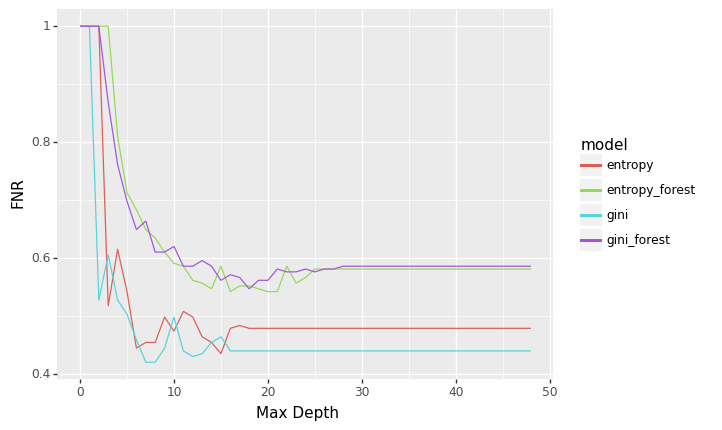

<ggplot: (-9223363306189482152)>

In [ ]:
ggplot(model_fnr) +\
  geom_line(aes(x = "ind", y = "fnr", colour = "model")) +\
  labs(x = "Max Depth", y = "FNR")

What we can conclude from above is that when using criterion = "gini" and max_depth = 7, it produces the best results in terms of FNR.  

In [ ]:
clf = DecisionTreeClassifier(random_state=3101,
                               criterion="gini", 
                               max_depth=7)

# Train Decision Tree Classifer & test on test set
clf = clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)

cm = pd.DataFrame(confusion_matrix(y_pred, y_test))
cm.columns = ['True Y=0','True Y=1']
cm.index = ['Predicted Y=0','Predicted Y=1']

display(cm)
print("\n")
specificity = cm.iloc[0, 0]/(cm.iloc[0, 0] + cm.iloc[1, 0])

def FNR(y_pred, y_test):
  cm = pd.DataFrame(confusion_matrix(y_pred, y_test))
  FN = cm.iloc[0, 1]
  TP = cm.iloc[1, 1]
  return FN/(FN + TP)
FN = cm.iloc[0, 1]
TP = cm.iloc[1, 1]
print("FNR:", round(FN/(FN + TP), 4))

print("Accuracy:",round(accuracy_score(y_test, y_pred),4))
print('Specificity:', round(specificity,4))
print('Sensitivity',round(recall_score(y_test,y_pred),4))
print('F1-Score:', round(f1_score(y_test,y_pred),4))
print('AUC:',round(roc_auc_score(y_test, y_pred),4))
print("\n")
feature_imp(clf)[:10]

,True Y=0,True Y=1
Predicted Y=0,682,94
Predicted Y=1,82,111




FNR: 0.4585
Accuracy: 0.8184
Specificity: 0.8927
Sensitivity 0.5415
F1-Score: 0.5578
AUC: 0.7171




[('Cooking Sauces', 0.231),
 ('BMI', 0.226),
 ('Biscuits', 0.07),
 ('Eggs', 0.052),
 ('TotalCalories', 0.052),
 ('Sugar', 0.03),
 ('Monetary', 0.027),
 ('Rice', 0.027),
 ('Snack', 0.027),
 ('Liquid Milk', 0.026)]

# Recommending based on Income and BMI

Now we will try to make recommendations to customers that have been classified as churned to try to win them back. The strategy will be to recommend them products that non-churned customers bought in hopes that these products are good products that has the power to convince customers to stay. To further personalise these recommendations, we will be grouping the customers based on BMI and income levels to give more targeted recommendations.

In [ ]:
print(df_decision_tree["Income"].unique())
print(df_decision_tree["BMI"].unique())


[1750 1000 2500 4500 3500 5500]
[1 4 2 3]


## Splitting into 12 clusters

Since we have 6 distinct Income values, we will split them into 3 groups: Low, Medium, and High, represented by 1,2,3.

In [ ]:
df_decision_tree['Income Group'] = df_decision_tree.apply(lambda row: 1  if row["Income"] <=1750 else 3 if row["Income"] >= 4500 else 2, axis=1)

From the levels of BMI and income, we create 12 clusters.

In [ ]:
df_decision_tree['Cluster'] = df_decision_tree.apply(lambda row: row["BMI"] + 4*(row["Income Group"]-1), axis = 1)
df_decision_tree["Cluster"].unique()

array([ 1.,  4.,  2.,  8.,  9.,  5.,  6.,  3., 10., 12., 11.,  7.])

In [ ]:
df_decision_tree.head()

,Monetary,Baby Cereal,Beer,Belacan,Bird Nest,Biscuits,Bouilon,Butter,CSD,Cake,Canned Product,Cereal Beverage,Cereals,Cheese,Chicken Essence,Choc/Nut Spread,Chocolate,Coconut Milk,Coffee,Condensed/Evap Milk,Confectionery,Cooking Oils,Cooking Sauces,Cordials,Creamer,Cultured Milk,Drinking Water,Eggs,Energy Drinks,Flour,Frozen Food,Fruit/Veg Juices,Ghee,Honey,Ice Cream,Instant Noodles,Instant Soup,Isotonic Drinks,Jam,Kaya,...,Milk Powder-Infant,Milk Powder-Kids,Peanut Butter,RTD Coffee,RTD Tea,Rice,Salad Dressing,Savoury Spread,Seasoning Powder,Snack,Soy Milk,Spagetti,Spirits,Sugar,Tea,Tonic Food Drink,Wine,Yoghurt Drink,Yoghurts,BMI,Income,Strata,#HH,Lifestage_Empty Nesters,Lifestage_Matured Families,Lifestage_Nesting Families,Lifestage_Teens Aches,Lifestage_Teens and Toddlers,Lifestage_Yankys,location_Central,location_East Coast,location_North,location_South,ethnic_Chinese,ethnic_Malay,ethnic_Others,TotalCalories,cherned,Income Group,Cluster
Panel 101011101,30.807778,0.0,0.0,0.0,0.0,19.0,6.0,8.0,49.0,3.0,13.0,3.0,5.0,1.0,0.0,1.0,4.0,32.0,20.0,13.0,0.0,21.0,29.0,7.0,0.0,3.0,11.0,9.0,0.0,32.0,3.0,4.0,0.0,0.0,1.0,11.0,0.0,1.0,2.0,0.0,...,0.0,0.0,1.0,0.0,1.0,23.0,3.0,0.0,32.0,13.0,1.0,1.0,0.0,128.0,2.0,3.0,0.0,0.0,0.0,1,1750,0,2,1,0,0,0,0,0,0,0,1,0,0,1,0,3134.954128,0,1,1.0
Panel 101016101,26.891667,0.0,0.0,0.0,0.0,22.0,16.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,3.0,51.0,0.0,54.0,44.0,3.0,0.0,1.0,0.0,8.0,0.0,23.0,3.0,0.0,0.0,0.0,0.0,7.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,21.0,1.0,0.0,47.0,1.0,0.0,0.0,0.0,70.0,6.0,20.0,0.0,0.0,0.0,4,1750,0,2,0,0,0,1,0,0,0,0,1,0,0,1,0,2670.116901,0,1,4.0
Panel 101019101,45.103788,0.0,0.0,4.0,0.0,53.0,0.0,0.0,9.0,1.0,39.0,0.0,6.0,0.0,0.0,0.0,21.0,104.0,283.0,43.0,0.0,75.0,10.0,10.0,0.0,15.0,0.0,218.0,0.0,6.0,1.0,2.0,0.0,0.0,2.0,91.0,0.0,17.0,0.0,1.0,...,0.0,0.0,1.0,0.0,1.0,65.0,0.0,0.0,146.0,12.0,3.0,0.0,0.0,270.0,6.0,123.0,0.0,6.0,0.0,1,1000,0,4,0,0,0,1,0,0,0,0,1,0,0,1,0,4745.492810,0,1,1.0
Panel 101024101,39.096970,0.0,0.0,0.0,0.0,98.0,5.0,0.0,10.0,24.0,96.0,5.0,1.0,10.0,0.0,0.0,3.0,0.0,26.0,0.0,16.0,18.0,24.0,0.0,0.0,50.0,0.0,45.0,0.0,26.0,133.0,10.0,0.0,1.0,16.0,104.0,2.0,10.0,0.0,1.0,...,0.0,0.0,1.0,2.0,11.0,21.0,5.0,1.0,7.0,165.0,39.0,19.0,0.0,9.0,6.0,29.0,0.0,14.0,4.0,2,1750,0,2,0,0,1,0,0,0,0,0,1,0,1,0,0,3223.792157,0,1,2.0
Panel 105009103,30.817424,0.0,0.0,0.0,0.0,73.0,6.0,0.0,0.0,2.0,97.0,23.0,0.0,0.0,0.0,0.0,0.0,0.0,128.0,0.0,6.0,131.0,60.0,7.0,0.0,0.0,8.0,122.0,0.0,0.0,0.0,0.0,0.0,0.0,35.0,21.0,0.0,11.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,16.0,0.0,0.0,236.0,0.0,9.0,0.0,0.0,12.0,0.0,124.0,0.0,0.0,0.0,2,1000,1,2,1,0,0,0,0,0,0,0,1,0,0,1,0,2360.576282,0,1,2.0


## Average basket size by cluster

We also want to find out how many items we should recommend to each customer. We will accomplish this by finding the average basket size per cluster.

In [ ]:
df_decision_join = df_decision_tree["Cluster"] 
df_hackdata_join =  df_hackdata.set_index('Panel ID').join(df_decision_join)
df_hackdata_join["Panel ID"] = df_hackdata_join.index
df_average_basket_size = df_hackdata_join[["Panel ID", "Category","Date"]].\
                          groupby(['Panel ID', 'Date']).\
                          count().\
                          reset_index().\
                          groupby(['Panel ID']).\
                          mean().\
                          reset_index().\
                          rename(columns = {"Category":"Average Basket Size",'Panel ID': 'ID'})
#df_average_basket_size['ID'] = df_average_basket_size.apply(lambda x: x["ID"].partition(" ")[2], axis=1)
df_average_basket_size = df_average_basket_size.set_index("ID").join(df_decision_join)
df_average_basket_size = df_average_basket_size.\
                          groupby("Cluster").\
                          mean().\
                          round().\
                          reset_index()
df_average_basket_size

,Cluster,Average Basket Size
0,1.0,6.0
1,2.0,6.0
2,3.0,5.0
3,4.0,6.0
4,5.0,6.0
5,6.0,6.0
6,7.0,5.0
7,8.0,5.0
8,9.0,6.0
9,10.0,5.0


## Recommendations by cluster

In [ ]:
add1_df = df_decision_tree.drop(df_decision_tree.columns[[0]+[i for i in range(63,83)]], axis = 1)
add1_df = add1_df.merge(df_average_basket_size, on = "Cluster", left_index = True)
add1_df.head()

,Baby Cereal,Beer,Belacan,Bird Nest,Biscuits,Bouilon,Butter,CSD,Cake,Canned Product,Cereal Beverage,Cereals,Cheese,Chicken Essence,Choc/Nut Spread,Chocolate,Coconut Milk,Coffee,Condensed/Evap Milk,Confectionery,Cooking Oils,Cooking Sauces,Cordials,Creamer,Cultured Milk,Drinking Water,Eggs,Energy Drinks,Flour,Frozen Food,Fruit/Veg Juices,Ghee,Honey,Ice Cream,Instant Noodles,Instant Soup,Isotonic Drinks,Jam,Kaya,Liquid Milk,MSG,Margarine,Milk Powder-Adult,Milk Powder-Infant,Milk Powder-Kids,Peanut Butter,RTD Coffee,RTD Tea,Rice,Salad Dressing,Savoury Spread,Seasoning Powder,Snack,Soy Milk,Spagetti,Spirits,Sugar,Tea,Tonic Food Drink,Wine,Yoghurt Drink,Yoghurts,Cluster,Average Basket Size
0,0.0,0.0,0.0,0.0,19.0,6.0,8.0,49.0,3.0,13.0,3.0,5.0,1.0,0.0,1.0,4.0,32.0,20.0,13.0,0.0,21.0,29.0,7.0,0.0,3.0,11.0,9.0,0.0,32.0,3.0,4.0,0.0,0.0,1.0,11.0,0.0,1.0,2.0,0.0,1.0,1.0,8.0,3.0,0.0,0.0,1.0,0.0,1.0,23.0,3.0,0.0,32.0,13.0,1.0,1.0,0.0,128.0,2.0,3.0,0.0,0.0,0.0,1.0,6.0
0,0.0,0.0,4.0,0.0,53.0,0.0,0.0,9.0,1.0,39.0,0.0,6.0,0.0,0.0,0.0,21.0,104.0,283.0,43.0,0.0,75.0,10.0,10.0,0.0,15.0,0.0,218.0,0.0,6.0,1.0,2.0,0.0,0.0,2.0,91.0,0.0,17.0,0.0,1.0,2.0,9.0,3.0,0.0,0.0,0.0,1.0,0.0,1.0,65.0,0.0,0.0,146.0,12.0,3.0,0.0,0.0,270.0,6.0,123.0,0.0,6.0,0.0,1.0,6.0
0,0.0,0.0,8.0,0.0,11.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,53.0,0.0,4.0,11.0,3.0,0.0,0.0,0.0,0.0,122.0,0.0,2.0,0.0,0.0,0.0,0.0,9.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,0.0,0.0,162.0,0.0,0.0,0.0,0.0,50.0,3.0,1.0,0.0,0.0,0.0,1.0,6.0
0,0.0,0.0,89.0,3.0,31.0,0.0,0.0,4.0,0.0,2.0,0.0,2.0,0.0,0.0,0.0,1.0,0.0,1.0,26.0,2.0,23.0,81.0,9.0,0.0,4.0,0.0,63.0,0.0,107.0,0.0,0.0,0.0,0.0,3.0,16.0,0.0,40.0,0.0,2.0,4.0,10.0,19.0,12.0,0.0,0.0,0.0,0.0,0.0,106.0,10.0,0.0,103.0,106.0,0.0,0.0,0.0,127.0,15.0,7.0,0.0,1.0,0.0,1.0,6.0
0,2.0,0.0,2.0,0.0,108.0,16.0,2.0,39.0,3.0,0.0,0.0,5.0,0.0,0.0,0.0,29.0,1.0,45.0,76.0,12.0,161.0,80.0,13.0,0.0,27.0,0.0,86.0,0.0,61.0,18.0,1.0,1.0,1.0,11.0,82.0,0.0,0.0,0.0,0.0,5.0,22.0,2.0,1.0,1.0,0.0,0.0,0.0,3.0,100.0,0.0,0.0,84.0,121.0,0.0,0.0,0.0,218.0,24.0,79.0,0.0,0.0,0.0,1.0,6.0


In [ ]:
cate_list= ['Biscuits',
 'Bouilon',
 'Butter',
 'CSD',
 'Cake',
 'Canned Product',
 'Cereal Beverage',
 'Cereals',
 'Cheese',
 'Choc/Nut Spread',
 'Chocolate',
 'Coconut Milk',
 'Coffee',
 'Condensed/Evap Milk',
 'Cooking Oils',
 'Cooking Sauces',
 'Cordials',
 'Cultured Milk',
 'Drinking Water',
 'Eggs',
 'Flour',
 'Frozen Food',
 'Fruit/Veg Juices',
 'Ice Cream',
 'Instant Noodles',
 'Isotonic Drinks',
 'Jam',
 'Liquid Milk',
 'MSG',
 'Margarine',
 'Milk Powder-Adult',
 'Peanut Butter',
 'RTD Tea',
 'Rice',
 'Salad Dressing',
 'Seasoning Powder',
 'Snack',
 'Soy Milk',
 'Spagetti',
 'Sugar',
 'Tea',
 'Tonic Food Drink',
 'Belacan',
 'Kaya',
 'Yoghurt Drink',
 'Confectionery',
 'Honey',
 'Instant Soup',
 'RTD Coffee',
 'Savoury Spread',
 'Yoghurts',
 'Milk Powder-Kids',
 'Ghee',
 'Baby Cereal',
 'Milk Powder-Infant',
 'Bird Nest',
 'Energy Drinks',
 'Beer',
 'Chicken Essence',
 'Wine',
 'Creamer',
 'Spirits']

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
def recommend_profile(panelid):
    panelid = "Panel "+panelid
    cluster = int(add1_df.loc[panelid,"Cluster":])
    df = add1_df[add1_df["Cluster"]==cluster]
    df=df.drop(["Cluster"],axis=1)
    cosinelist = []
    uservec = df.loc[panelid,:].to_numpy()
    indexofuser = df.index.get_loc(panelid)
    for i in range(0,len(df)):
        if i == indexofuser:
            continue
        v = df.iloc[i,:].to_numpy()
        cos = cosine_similarity([uservec], [v])
        cosinelist.append([i,cos[-1][-1]])
        
    cossort=sorted(cosinelist,key = lambda s: s[1],reverse = True)
    
    k=20
    min_k = 5
    np.random.seed(3101)
    np.set_printoptions(suppress=True)
    neighbors=[]
    for j in range(0,min(len(df)-1,k)):
        v = round(df.iloc[cossort[j][0],:],1).to_list()
        neighbors.append(v)
    neighbors = np.array(neighbors)
    ave = np.around(neighbors.mean(axis = 0),decimals = 2)
    return ave

In [ ]:
def recommend_list(id):
    ave = recommend_profile(id).tolist()
    id = "Panel "+ id
    cluster = int(add1_df.loc[id,"Cluster":])
    #basket_size = add1_df.loc[id,"Average Basket Size":]
    print(basket_size)
    df = add1_df[add1_df["Cluster"]==cluster]
    df=df.drop(["Cluster"],axis=1)
    uservec = df.loc[id,:].to_numpy().tolist()
    
    recommend=[]
    for i in range(len(cate_list)):
        if uservec[i]>1 and ave[i]!=1:
            recommend.append([cate_list[i], ave[i]-1])
    return sorted(recommend, key = lambda x:x[1],reverse=True)

In [ ]:
recommend_profile("105009103")


TypeError: ignored

## Value of each non-churned customer

Finding average amount spent among non churned customers in 2018

In [ ]:
df_hackdata_2018_value = df_hackdata[(df_hackdata["Date"] > '2017-12-31') & (df_hackdata["Date"] < '2019-01-01')][["Panel ID", "Spend"]].\
                          groupby("Panel ID").\
                          sum("Spend")
df_hackdata_2018_value = df_hackdata_2018_value.join(df_decision_tree[["Cluster", "cherned"]])
df_hackdata_2018_value= df_hackdata_2018_value[df_hackdata_2018_value["cherned"]== 0]
df_hackdata_2018_value = df_hackdata_2018_value.groupby("Cluster").\
                        mean("Spend").\
                        drop("cherned",axis = 1)
df_hackdata_2018_value

,Spend
Cluster,
1.0,1658.275000
2.0,1621.163462
3.0,1795.145918
4.0,1678.086207
5.0,1942.554630
6.0,2101.143147
7.0,1909.536975
8.0,1811.914676
9.0,2505.014458
